# QITE - Evaluation

In [ ]:
from typing import List, Tuple, Dict, Any, Optional, Union, Set
from multiprocessing import Pool
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path
from dataclasses import dataclass, field

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
PLATFORMS = [
    'qiskit', 'pennylane', 'pytket',
    # 'bqskit'
]

## RQ: Comparison with Prior Work

In [13]:
EXPERIMENTS_MORPHQ = {
    "v14": {
        "path": "/home/paltenmo/projects/morphq_upgraded/MorphQ-Quantum-Qiskit-Testing-ICSE-23/data/qmt_v14",
        "description": "MorphQ Data - 1h - Qiskit"
    }
}
# add provenance field to the data
EXPERIMENTS_MORPHQ = {
    k: {**v, "provenance": "morphq"} for k, v in EXPERIMENTS_MORPHQ.items()
}

EXPERIMENTS_QITE = {
    "2025_03_07__16_41": {
        "path": "../program_bank/v045/2025_03_07__16_41",
        "description": "1h - 3 platforms  - threads + converters"
    },
}
# add provenance field to the data
EXPERIMENTS_QITE = {
    k: {**v, "provenance": "qite"} for k, v in EXPERIMENTS_QITE.items()
}

EXPERIMENTS_ALL = {
    **EXPERIMENTS_MORPHQ,
    **EXPERIMENTS_QITE
}
SELECTED_EXP_QITE = "2025_03_07__16_41"
SELECTED_EXP_MORPHQ = "v14"

In [22]:
# todo add coverage data to a dictionary to use later easily for the venn
COVERAGE_DATA_ALL = {}

for exp_name, exp_info in EXPERIMENTS_ALL.items():
    print(
        f"Experiment: {exp_name} - ({exp_info['description']}) - {exp_info['provenance']}")
    exp_coverage_data_path = Path(exp_info["path"]) / "coverage_platforms.json"
    with open(exp_coverage_data_path, "r") as f:
        exp_coverage_data = json.load(f)
    COVERAGE_DATA_ALL[exp_name] = exp_coverage_data
    for package, coverage in exp_coverage_data.items():
        print(
            f"{package:_<15}: {coverage['coverage_percentage']:.2f}% ({coverage['covered']}/{coverage['total']})")

Experiment: v14 - (MorphQ Data - 1h - Qiskit) - morphq
qiskit_________: 9.49% (6904/72751)
pennylane______: 0.00% (0/0)
pytket_________: 0.00% (0/0)
Experiment: 2025_03_07__16_41 - (1h - 3 platforms  - threads + converters) - qite
qiskit_________: 13.93% (10133/72751)
pennylane______: 26.90% (12781/47509)
pytket_________: 30.12% (11572/38416)



Experiment: 2025_03_07__16_41
Description: 1h - 3 platforms  - threads + converters


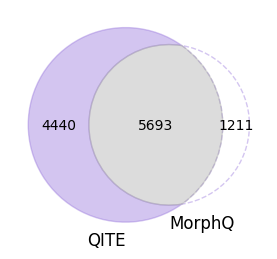

\newcommand{\QITEQiskitCoverage}{13.93\%}
\newcommand{\MorphQQiskitCoverage}{9.49\%}
\newcommand{\QITEQiskitTotalLines}{72751}
\newcommand{\MorphQQiskitTotalLines}{72751}
\newcommand{\QITEQiskitCoveredLines}{10133}
\newcommand{\MorphQQiskitCoveredLines}{6904}
\newcommand{\CoveredSharedLines}{5693}
\newcommand{\CoveredOnlyQITE}{4440}
\newcommand{\CoveredOnlyMorphQ}{1211}


In [26]:
from matplotlib_venn import venn2

# Styling constants
FIGURE_SIZE = (6, 3)
# light purple, light gray, white
STYLE_COLORS = ['mediumpurple', 'darkgray', 'white']
OUTPUT_IMAGE_PATH = "images/rq_coverage_venn_vs_morphq.pdf"


@dataclass
class VennDiagramData:
    """Data structure for Venn diagram components."""
    exclusive_set1: Set[str]
    exclusive_set2: Set[str]
    intersection: Set[str]


def calculate_venn_sets(set1: Set[str], set2: Set[str]) -> VennDiagramData:
    """Calculate exclusive and intersection sets for Venn diagram."""
    return VennDiagramData(
        exclusive_set1=set1 - set2,
        exclusive_set2=set2 - set1,
        intersection=set1 & set2,
    )


def style_venn_diagram(venn: Any, data: VennDiagramData) -> None:
    """Apply styling to Venn diagram components."""
    # Set size labels
    for id, size in [
        ('10', len(data.exclusive_set1)),
        ('01', len(data.exclusive_set2)),
        ('11', len(data.intersection))
    ]:
        venn.get_label_by_id(id).set_text(size)

    # Style sections
    venn.get_patch_by_id('10').set_color(STYLE_COLORS[0])
    patch01 = venn.get_patch_by_id('01')
    patch01.set_edgecolor(STYLE_COLORS[0])
    patch01.set_linestyle('dashed')
    patch01.set_facecolor('white')
    venn.get_patch_by_id('11').set_color(STYLE_COLORS[1])


def create_coverage_venn_diagram(
    qite_lines: Set[str],
    morphq_lines: Set[str],
    qite_label: str = 'QITE',
    morphq_label: str = 'MorphQ',
) -> Tuple[plt.Figure, plt.Axes, VennDiagramData]:
    """Create and style Venn diagram comparing covered lines."""
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    venn_data = calculate_venn_sets(qite_lines, morphq_lines)

    venn = venn2(
        subsets=[qite_lines, morphq_lines],
        set_labels=(qite_label, morphq_label),
        ax=ax,
    )
    style_venn_diagram(venn, venn_data)

    plt.show()
    fig.savefig(OUTPUT_IMAGE_PATH)
    return fig, ax, venn_data


def print_latex_commands(
    cov_qiskit_ours: dict,
    cov_qiskit_morphq: dict,
    venn_data: VennDiagramData,
) -> None:
    """
    Print LaTeX commands for coverage statistics.

    Args:
        cov_qiskit_ours: Coverage data from QITE approach
        cov_qiskit_morphq: Coverage data from MorphQ approach
        venn_data: VennDiagramData containing set intersection info
    """
    coverage_commands = [
        ("QITEQiskitCoverage",
            f"{cov_qiskit_ours['coverage_percentage']:.2f}\\%"),
        ("MorphQQiskitCoverage",
            f"{cov_qiskit_morphq['coverage_percentage']:.2f}\\%"),
        ("QITEQiskitTotalLines",
            f"{cov_qiskit_ours['total']}"),
        ("MorphQQiskitTotalLines",
            f"{cov_qiskit_morphq['total']}"),
        ("QITEQiskitCoveredLines",
            f"{cov_qiskit_ours['covered']}"),
        ("MorphQQiskitCoveredLines",
            f"{cov_qiskit_morphq['covered']}"),
        ("CoveredSharedLines", f"{len(venn_data.intersection)}"),
        ("CoveredOnlyQITE", f"{len(venn_data.exclusive_set1)}"),
        ("CoveredOnlyMorphQ", f"{len(venn_data.exclusive_set2)}"),
    ]

    for cmd_name, value in coverage_commands:
        print(f"\\newcommand{{\\{cmd_name}}}{{{value}}}")


cov_morphq = COVERAGE_DATA_ALL[SELECTED_EXP_MORPHQ]

for exp_name in [SELECTED_EXP_QITE]:
    print(f"\nExperiment: {exp_name}")
    print(f"Description: {EXPERIMENTS_ALL[exp_name]['description']}")
    cov_qite = COVERAGE_DATA_ALL[exp_name]
    # Example usage remains the same but with named arguments
    fig, ax, venn_data = create_coverage_venn_diagram(
        qite_lines=set(cov_qite["qiskit"]["covered_lines"]),
        morphq_lines=set(cov_morphq["qiskit"]["covered_lines"]),
    )
    print_latex_commands(
        cov_qiskit_ours=cov_qite["qiskit"],
        cov_qiskit_morphq=cov_morphq["qiskit"],
        venn_data=venn_data,
    )

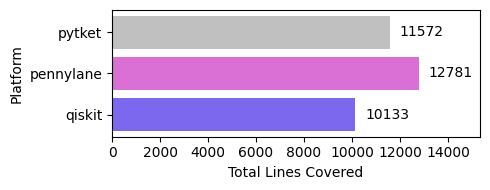

\newcommand{\QITEQiskitTotalLines}{72751}
\newcommand{\QITEQiskitCoveredLines}{10133}
\newcommand{\QITEPennylaneTotalLines}{47509}
\newcommand{\QITEPennylaneCoveredLines}{12781}
\newcommand{\QITEPytketTotalLines}{38416}
\newcommand{\QITEPytketCoveredLines}{11572}


In [28]:
PLATFORM_COLORS = {'qiskit': 'mediumslateblue',
                   'pytket': 'silver', 'pennylane': 'orchid'}
OUTPUT_DIR = "images"
OUTPUT_PATH_BAR_PLOT = os.path.join(OUTPUT_DIR, "rq_coverage_barplot.pdf")


def create_platform_bar_plot(package_coverage, platforms, output_path):
    """Generates and saves a horizontal bar plot of platform coverage."""
    platform_colors = [PLATFORM_COLORS[platform] for platform in platforms]
    total_lines_covered = [package_coverage[platform]['covered']
                           for platform in platforms]

    fig, ax = plt.subplots(figsize=(5, 2))
    bars = ax.barh(platforms, total_lines_covered, color=platform_colors)
    ax.set_xlabel('Total Lines Covered')
    ax.set_ylabel('Platform')

    max_val = max(total_lines_covered)
    add_bar_value_labels(ax, bars, total_lines_covered, max_val)

    ax.set_xlim(0, max_val * 1.2)
    fig.tight_layout()
    plt.show()
    fig.savefig(output_path)


def add_bar_value_labels(ax, bars, values, max_val):
    """Adds labels to the end of each bar in a horizontal bar plot."""
    for bar, value in zip(bars, values):
        ax.text(value + (max_val / 30), bar.get_y() + bar.get_height() / 2,
                f'{value}', va='center', ha='left')


def print_latex_commands(package_coverage, platforms):
    """Prints LaTeX commands for total and covered lines for each platform."""
    for platform in platforms:
        total_lines = package_coverage[platform]['total']
        covered_lines = package_coverage[platform]['covered']
        print(
            f"\\newcommand{{\\QITE{platform.capitalize()}TotalLines}}{{{total_lines}}}")
        print(
            f"\\newcommand{{\\QITE{platform.capitalize()}CoveredLines}}{{{covered_lines}}}")


# Main execution
create_platform_bar_plot(
    package_coverage=COVERAGE_DATA_ALL[SELECTED_EXP_QITE],
    platforms=PLATFORMS,
    output_path=OUTPUT_PATH_BAR_PLOT,
)
print_latex_commands(
    package_coverage=COVERAGE_DATA_ALL[SELECTED_EXP_QITE],
    platforms=PLATFORMS)